# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Fengyu Cai, Wanhao Zhou
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

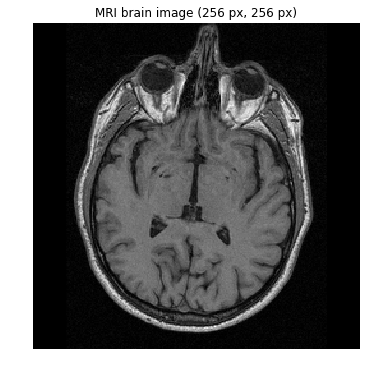

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Reference: Page 13, Lecture 2, Image Analysis and Pattern Recogition, EPFL

In [3]:
# 1.2 import
import numpy as np
from skimage.morphology import dilation, erosion, opening, closing

#### Predefined functions

In [4]:
def axPlot(img, title=''):
    """
        Based on our requirement, plot the image
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    plt.title(title)
    plt.show()

In [5]:
def checkinside(x, y, img):
    """
        This function is used to check whether the point (x, y) is in the legal region of img
    """
    return x < np.shape(img)[0] and x >= 0 and y < np.shape(img)[1] and y >= 0

In [6]:
def regionGrow(img, seed):
    """
        This function is the main body to grow the region, and calculate the area of the region
        return: np.darray
        img: np.darray
        seed: start position of the algo
    """
    # get the max and min of img, and the difference between them will be used for normalization
    img_max = np.max(img)
    img_min = np.min(img)
    normal_diff = (img_max - img_min) * 0.12
    
    # get the return map, the same shape as img, but filled with full
    img_ret = np.zeros_like(img)
    region_mean = img[seed[0], seed[1]]
    
    # use a queue to record the border of segimg
    q = []
    
    # add the start point in
    q.append(seed)
    
    # 4 neighbor points
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    nsize = 1
    
    
    
    while q:
        px, py = q.pop(0)
        tmp_record = []
        tmp_pos = []
        
        if checkinside(px, py, img) and img_ret[px, py] == 1:
            continue
        
        for nb in neighbors:
            pnx = px + nb[0]
            pny = py + nb[1]
            
            if checkinside(pnx, pny, img) and img_ret[pnx, pny] != 1:
                tmp_record.append(img[pnx, pny])
                tmp_pos.append([pnx, pny])
         
        if tmp_record:
            if np.mean(np.abs(tmp_record - region_mean)) < normal_diff:
                img_ret[px, py] = 1
                q.extend(tmp_pos)
                # update the region mean
                region_mean = (region_mean * nsize + img[px, py]) / (nsize+1)
                nsize+=1
    return img_ret

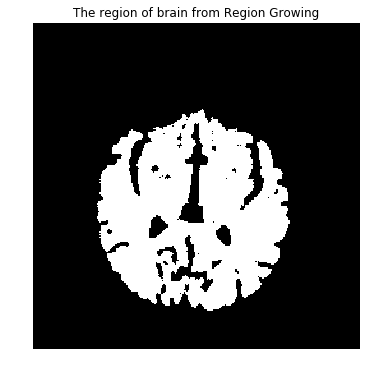

In [7]:
resultRegionGrowing = regionGrow(brain_im, [150, 150])
axPlot(resultRegionGrowing, 'The region of brain from Region Growing')

<font color='red' size=5>Verification</font>

We would like to verify our result through masking our result on the original picture.

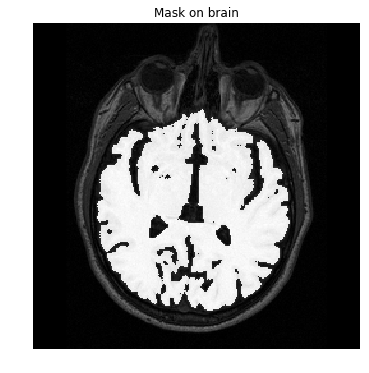

In [8]:
mask = resultRegionGrowing * 300
axPlot(mask + brain_im, 'Mask on brain')

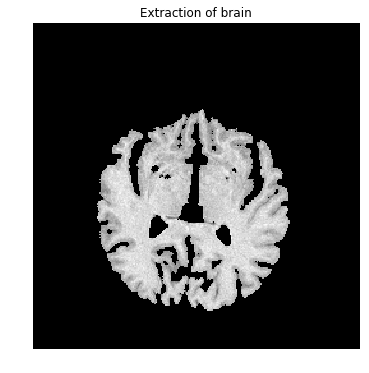

In [9]:
axPlot(resultRegionGrowing * brain_im, 'Extraction of brain')

In [10]:
print('The estimated brain area from the method of region growing is {}'.format(np.sum(resultRegionGrowing)))

The estimated brain area from the method of region growing is 15142


### 1.3 Contour detection
Reference: Page 13, Lecture 2, Image Analysis and Pattern Recogition, EPFL

In [11]:
# 1.3 import
import numpy as np
from skimage.filters import roberts, sobel, prewitt, sobel_h, sobel_v
from skimage.measure import regionprops
from skimage import data, segmentation, filters
from skimage.morphology import dilation, erosion, opening, closing, reconstruction, disk
from skimage import color

#### Predefined function

In [12]:
def setBG(img):
    """
        Input: image, np.darray
        Output: image after removing the background, np.darray
    """
    height = img.shape[0]
    for i in range(height):
        mask = np.where(img[i,:]>0)[0]
        if mask.size:
            begin = mask[0]
            end = mask[-1]
            img[i, :begin] = 1
            img[i, end:] = 1
        else:
            img[i,:] = 1
    return img.astype(int)

####  Step1: Three Methods of Edge Detection
As discussioned in our lecture, there are three methods of edge detection: roberts, sobel, and prewitt. We will use all of them to detect the contour. After that, we did some morphological operations to clean the outliers, and consolidate our result.

In [13]:
# three edge detection methods
edge_roberts = roberts(brain_im)
edge_sobel = sobel(brain_im)
edge_prewitt = prewitt(brain_im)

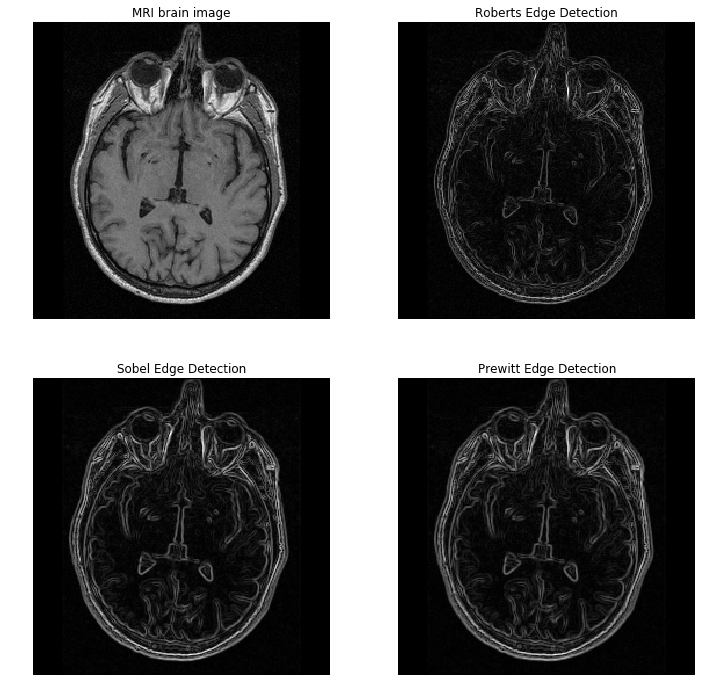

In [14]:
# plot the result
fig, ax = plt.subplots(2,2, figsize=(12, 12))
ax[0][0].imshow(brain_im, cmap='gray')
ax[0][1].imshow(edge_roberts, cmap='gray')
ax[1][0].imshow(edge_sobel, cmap='gray')
ax[1][1].imshow(edge_prewitt, cmap='gray')
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[0][0].set_title('MRI brain image')
ax[0][1].set_title('Roberts Edge Detection')
ax[1][0].set_title('Sobel Edge Detection')
ax[1][1].set_title('Prewitt Edge Detection')
plt.show()

From our observation above, we find that there is no obvious difference in the outcomes of three methods. Therefore, we only take one of them for the next step randomly, and here we choose the result of <font color='red'>Sobel Edge Detection</font>.

#### Step2: clean and stress the border

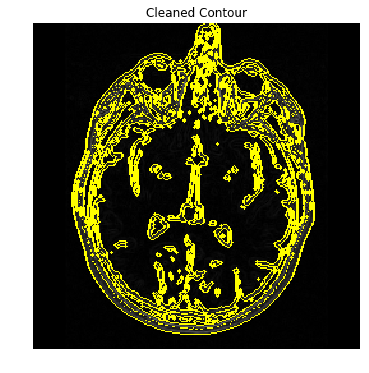

In [15]:
binaryImg = edge_sobel > filters.threshold_otsu(edge_sobel)
clean_border = segmentation.clear_border(binaryImg).astype(np.int)
edges_cleaned = segmentation.mark_boundaries(edge_sobel, clean_border)
axPlot(edges_cleaned, 'Cleaned Contour')

From the image above, we find that there are a lot of thin and inconnectedf contours. And we need to conbines them to a more complete and clear contour. And here, we a reconstruction method.

#### Step3: Morphological Operations
After getting the clean and complete contours, we need to isolate the region of the brain.

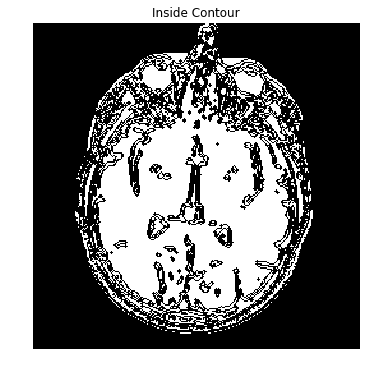

In [16]:
# Firstly, remove the background first
edged_gray = color.rgb2gray(edges_cleaned)
edged_binary = (edged_gray>0.15).astype(np.int)
insideContour = -(setBG(edged_binary) - 1)
axPlot(insideContour, 'Inside Contour')

A series of morphological operations will help to clean the outliers

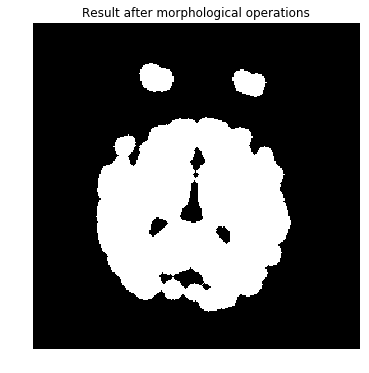

In [17]:
tmp1 = erosion(insideContour, selem=disk(4))
tmp2 = dilation(tmp1, selem=disk(8))
morphologicalResult = erosion(tmp2, selem=disk(2))
axPlot(morphologicalResult, 'Result after morphological operations')

#### Step4: find the useful part
Based on the result of our last step, we choose to manually choose the area to remove two 'eyes' on the image. We won't use morphological methods any longer in order to maintain the completeness of contour.

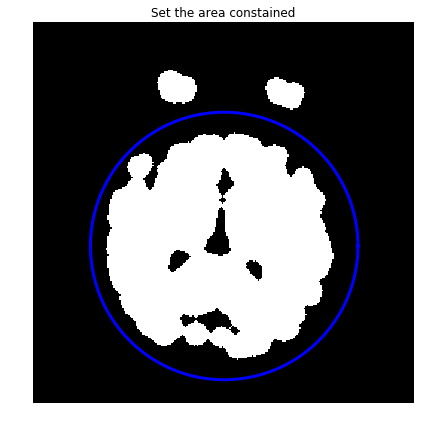

In [18]:
centerx = 128
centery = 150
r = 90
s = np.linspace(0, 2*np.pi, 400)
x = centerx + r*np.cos(s)
y = centery + r*np.sin(s)
init = np.array([x, y]).T
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(morphologicalResult, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '-b', lw=3)
plt.title('Set the area constained')
ax.axis('off')
plt.show()

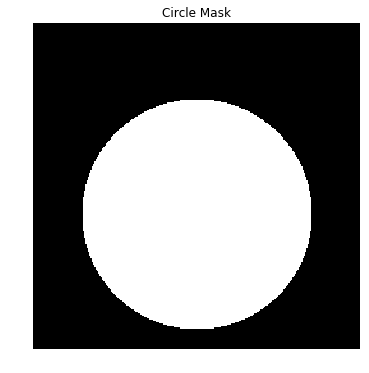

In [19]:
circle = np.zeros_like(morphologicalResult)
for i in range(np.shape(morphologicalResult)[0]):
    for j in range(np.shape(morphologicalResult)[1]):
        circle[i, j] = int((j - centerx) ** 2 + (i - centery) ** 2 < r ** 2)
axPlot(circle, 'Circle Mask')

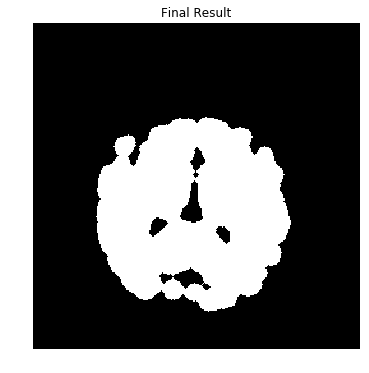

In [20]:
finalResult = circle * morphologicalResult
axPlot(finalResult, 'Final Result')

<font color='red' size=5>Verification</font>

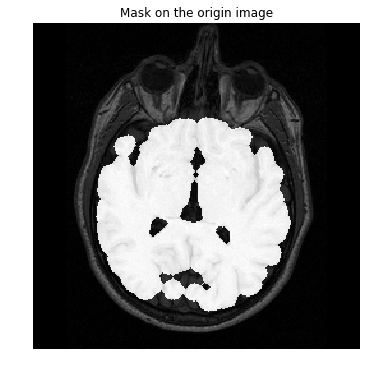

In [21]:
# show it as a mask
axPlot(finalResult*300 + brain_im, 'Mask on the origin image')

In [22]:
print('The area of brain using the methods of edge detection is {}'.format(np.sum(finalResult)))

The area of brain using the methods of edge detection is 16690


### 1.4 Additional method(s)
In this part, we will use two additional methods to extract the region of brain. The first one is based on the active contour, while the second one is the superposition of the regions inside contours.

### 1.4.1 Active Contour

Here, we use the function active_contour from segmentation module in skimage. The area is obviously larger than the first two we have implemented, and the main reason is that it can not reach the inner hole of the brain.

In [23]:
# Active Contours Import
from skimage.filters import gaussian
from skimage.segmentation import active_contour

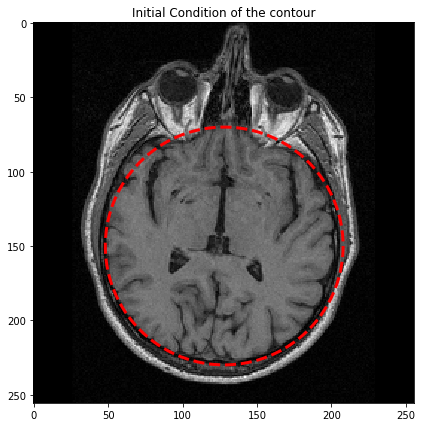

In [24]:
# set up the initial position
s = np.linspace(0, 2*np.pi, 400)
x = 128 + 80*np.cos(s)
y = 150 + 80*np.sin(s)
init = np.array([x, y]).T
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
plt.title('Initial Condition of the contour')
plt.show()

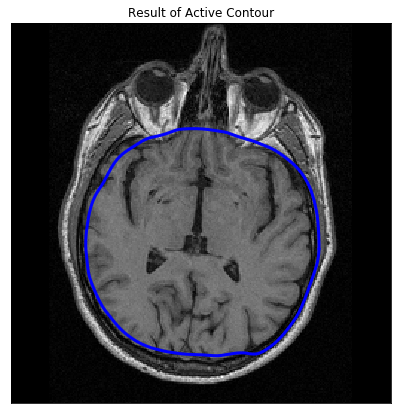

In [25]:
snake = active_contour(gaussian(brain_im, 3),
                       init, alpha=0.2, beta=0.05, gamma=0.01, max_iterations=5000, w_edge = 2)#, bc='fixed-fixed')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, brain_im.shape[1], brain_im.shape[0], 0])
plt.title('Result of Active Contour')
plt.show()

In [26]:
# calculate the area inside the contour
#calc the area
x = snake[:,0]
y = snake[:,1]
area = 0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
area = np.abs(area)
print('The area of brain using the methods of active edge detection is {}'.format(int(area)))

The area of brain using the methods of active edge detection is 19360


### 1.4.2 Superposition of Contours

In the section 1.3 Contour Detection, we have been met with the trouble removing two 'eyes' area. At that time, the method we chose to use is to manually remove it according to its position. However, in this part, we have come up with an alternative method, using find_contour() function to find out the contours. And transfer our result to <font color='red'>the addition or substract of the area of different contours</font>. And here, the result of this method is 16364, which isre very similar to the result of edge detection (16690).

In [27]:
from skimage import measure

In [28]:
def areaCalculator(contour):
    x=contour[:,0]
    y=contour[:,1]
    area=0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
    area=np.abs(area)
    return area

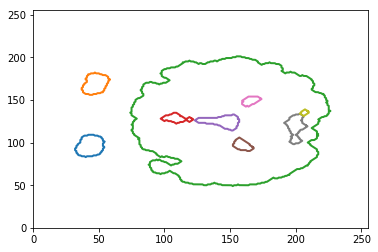

In [29]:
contours = measure.find_contours(morphologicalResult, 0.9, fully_connected="high")
fig, ax = plt.subplots()
plt.axis(xmin=0, xmax=255, ymin=0, ymax=255)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

From the picture above, in order to get the area of the brain, what we need to do is to remove two eyes, and use the area of green contour substracting other areas of inner contours as the final result.

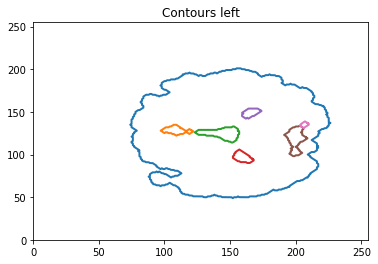

In [30]:
# remove the eyes
fig, ax = plt.subplots()
plt.axis(xmin=0, xmax=255, ymin=0, ymax=255)
contoursLeft = contours[2:]
plt.title('Contours left')
for idx in range(len(contoursLeft)):
    ax.plot(contoursLeft[idx][:, 0], contoursLeft[idx][:, 1], linewidth=2)

Use large one to substract smaller ones to get the brain size.

In [31]:
areaLarger = areaCalculator(contoursLeft[0])
areaSubtract = sum([areaCalculator(c) for c in contoursLeft[1:]])
print('The area of the brain region is {}'.format(int(areaLarger - areaSubtract)))

The area of the brain region is 16364


### Conclution
We have estimated the size of the brain with four methods as followed:

|  Methods |  Area |
|---|---|
|  Region Growing |  15142 |
|  Contour Detection |  16690 |
|  Active Contour |  19360 |
|  Superposition |  16364 |

We can conclude:
- 1. The result from Region Growing is the smallest, as this methods is expanding from inside. Therefore, it can perfectly detect the inner holes.
- 2. The contour detection and superpostion are similar. They are from the outside to inside, therefore, they will lose some of inner information.
- 3. Active contour is the poorest, as it can only get the outer range of the brain, totally ignore inner holes. Therefore, it is the largest.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [32]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


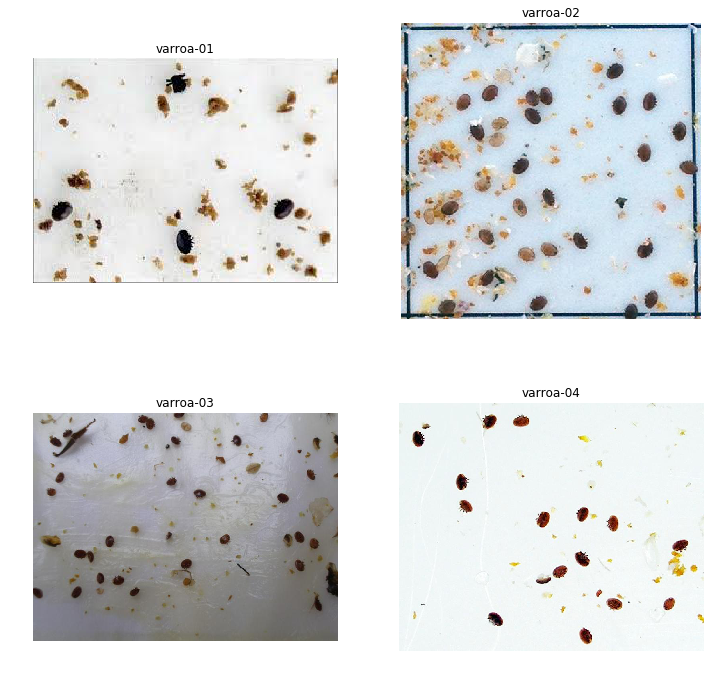

In [33]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [34]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [35]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

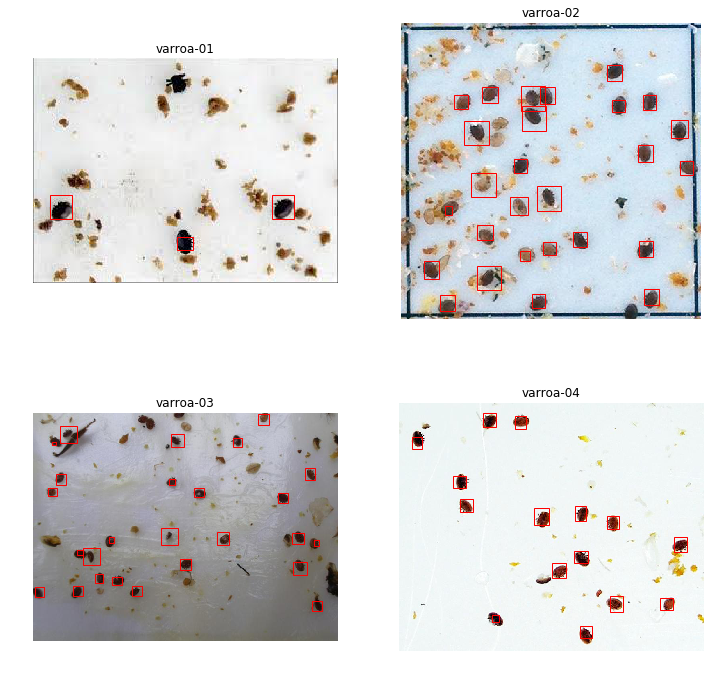

In [36]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

In this problem, I would like to briefly introduce our methods as followings:
- we firstly convert the RGB pictures to gray-level ones.
- After that, we applied `skimage.measure.label` to label our flies.
- We tried to use some existing function to find out the threshold like `threshold_otsu`, however, none of them fit well. Therefore, we use quantile instead.
- According to the features of the fly, we set up two constrains.
    - 1. the size of the fly cannot be too large or too small, both relative to the size of the whole picture
    - 2. the shape of the fly is close to a square, therefore, the ratio of width and height should be in certain range.


Hint: `skimage.measure.label` might be useful to label the thresholded image

In [37]:
# 2.2 Import
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu, threshold_yen, threshold_li, threshold_adaptive, threshold_isodata
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, opening
from skimage.color import label2rgb

In [38]:
def getLabel(originImg, quant, verbose=0):
    """
        Label the image
        input: originImg: np.darray
               quant: quantile value
        output: label_image: np.darray
                labels: list
                verbose: boolean to show the histogram
    """
    image = skimage.color.rgb2grey(originImg)
    cnt = 0
    borderWidth, borderHeight = np.shape(image)
    minArea = (borderWidth / 50) * (borderHeight / 50)
    maxArea = (borderWidth / 10) * (borderHeight / 10)
    
    # apply threshold
    thresh = np.quantile(image, quant)
    if verbose:
        plt.hist(np.reshape(image, (-1,)))
        plt.title('the threshold is {}'.format(thresh))
    # bw = closing(image > thresh, square(3))
    bw = closing(image < thresh)
    # remove artifacts connected to image border
    cleared = dilation(bw, selem=disk(1))
    
    # label image regions
    label_image = label(bw, neighbors=8, background=-1)
    image_label_overlay = label2rgb(label_image, image=image)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)
    
    # record the valid region
    regions = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= minArea and region.area <= maxArea:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox

            # calculate the ratio between width and heighth
            width = maxc - minc
            heighth = maxr - minr

            ratio = width / heighth
            if verbose:
                print('minr {} minc {} maxr {} maxc {}'.format(minr, minc, maxr, maxc))
            if ratio > 0.7 and ratio < 1/0.7:
                if verbose:
                    print('add in')
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                cnt += 1
                regions.append(region)
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.title('the count is {}'.format(cnt))
    plt.show()
    return label_image, regions, cnt

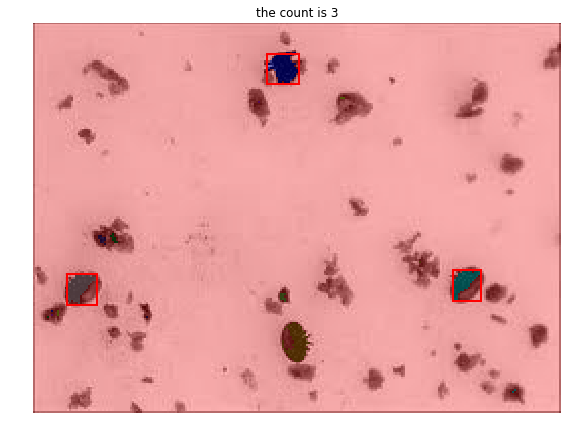

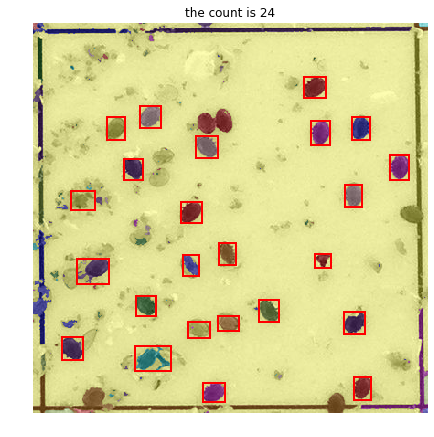

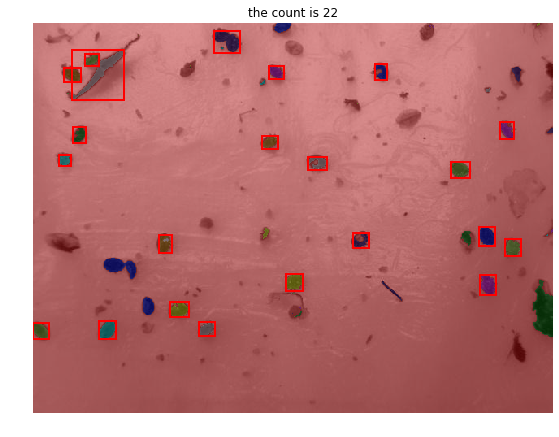

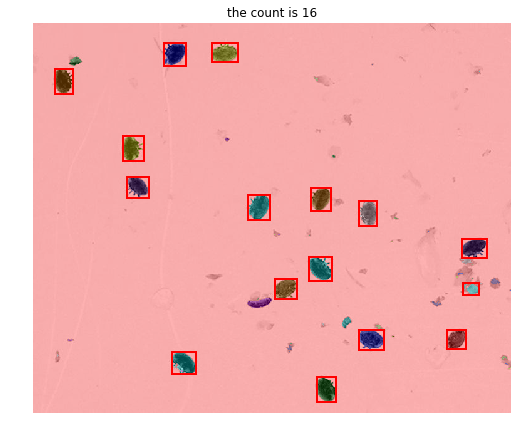

In [39]:
cntgt = [3, 27, 26, 15]
qList = [0.01, 0.1, 0.03, 0.03]
imgList = []
cntreal = []
regions = []
for imgInd in range(len(ic)):
    img, region, cnt_ = getLabel(ic[imgInd], qList[imgInd])
    imgList.append(img)
    regions.append(region)
    cntreal.append(cnt_)

Therefore, we can have a comparison between the count from out extraction and groundtruth.

In [40]:
for i in range(4):
    print('%dth pages test count: %d groundtruth count: %d' % (i + 1, cntreal[i], cntgt[i]))

1th pages test count: 3 groundtruth count: 3
2th pages test count: 24 groundtruth count: 27
3th pages test count: 22 groundtruth count: 26
4th pages test count: 16 groundtruth count: 15


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Based on the last result, we calculate IoU between our predicted result and the groundtruth. We find that it is very difficult for the prediction to perfectly match with the label in the groundtruth, namely, it is very difficult to reach 0.9.

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [41]:
def IoUperBlock(img, blocks, gtblock, verbose=0):
    """
        Input:
            img: np.darray
            blocks: list of the prediction ground
            gtblock: groundTruth
        return: IoU value
    """
    
    width, height = np.shape(img)

    res = []
    for block in blocks:
        imgOri = np.zeros((height, width))
        imggt = np.zeros_like(imgOri)
        
        minr, minc, maxr, maxc = block.bbox
        imgOri[minc:maxc, minr:maxr] = 1

        imggt[gtblock['bbox'][0]:gtblock['bbox'][0] + gtblock['bbox'][2], gtblock['bbox'][1]:gtblock['bbox'][1] + gtblock['bbox'][3]] = 1

        imgol = imggt.T + imgOri.T

        sizeI = np.sum(imgol == 2)
        sizeU = np.sum(imgol == 1) + np.sum(imgol == 2)
        if sizeI > 0:
            if verbose:
                print('IoU is %f' % (sizeI / sizeU))
                plt.imshow(imgol)
                plt.show()
            res.append(sizeI/sizeU)
    
    if res:
        return np.max(res)
    
    return 0.0

In [42]:
def IoU(image, label_image, regions, gtanno, verbose=0):
    """
        This function is to calculate all IoU scores for one set of groundtruth labels
        Input:
            image: original image: np.darray
            label_image: labelled image: np.ndarray
            regions: our labels: list
            gtanno: groundtruth labels: list
            verbose: show the intersection case: boolean
        Output:
            IoUList: each IoU for each of the region in groundtruth
    """
    res = []
    for anno in gtanno:
        res.append(IoUperBlock(label_image, regions, anno, verbose))
        
    image_label_overlay = label2rgb(label_image, image=image)
    if verbose:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(image_label_overlay)

        for anno in gtanno:
            rect = mpatches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)

        for region in regions:

            minr, minc, maxr, maxc = region.bbox

            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    return res

#### Display results
The following is the examples of the code operations. All of the four sample input are displayed as following.

IoU is 0.475610


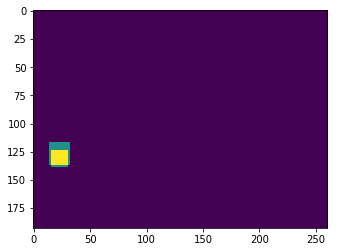

IoU is 0.552632


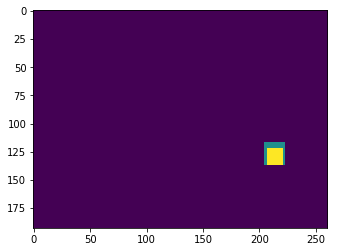

[0.47560975609756095, 0.5526315789473685, 0.0]

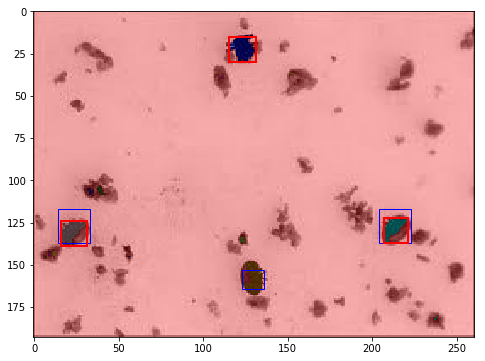

In [43]:
iou_figure1 = IoU(ic[0], imgList[0], regions[0], annotations_xmls[0], 1)
iou_figure1

IoU is 0.742424


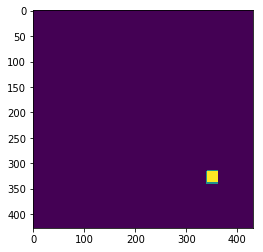

IoU is 0.798903


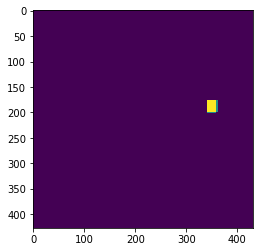

IoU is 0.669014


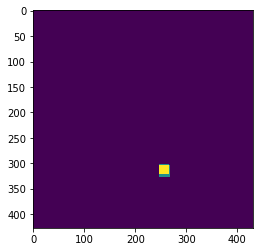

IoU is 0.756144


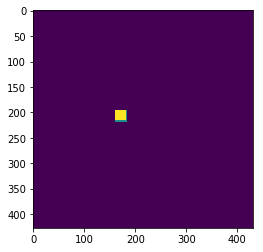

IoU is 0.586207


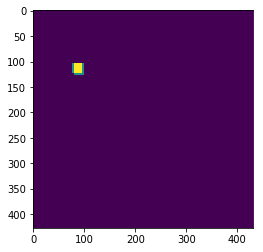

IoU is 0.500000


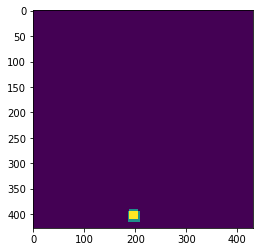

IoU is 0.811594


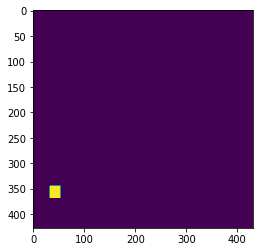

IoU is 0.582258


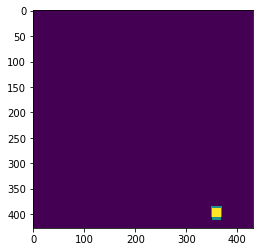

IoU is 0.698706


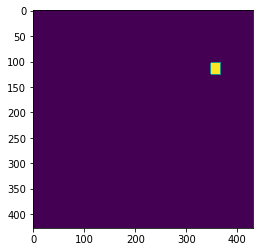

IoU is 0.449102


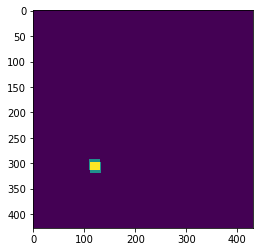

IoU is 0.843206


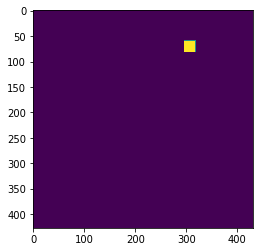

IoU is 0.560440


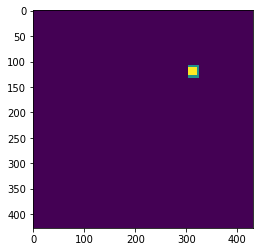

IoU is 0.846154


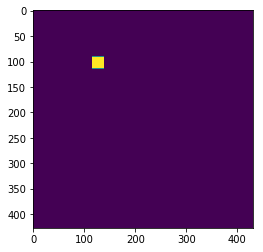

IoU is 0.587217


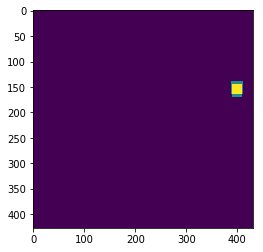

IoU is 0.544276


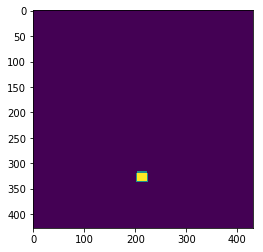

IoU is 0.486111


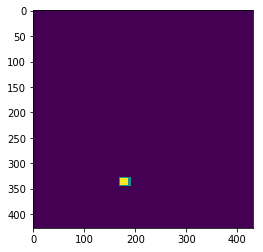

IoU is 0.560720


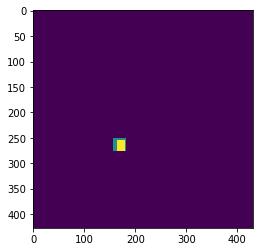

IoU is 0.147119


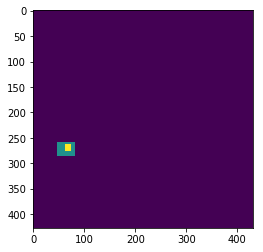

IoU is 0.387755


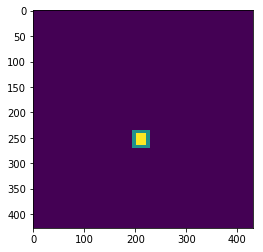

IoU is 0.411429


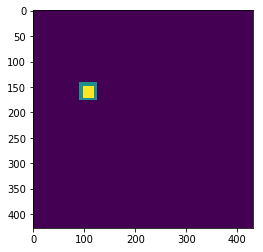

IoU is 0.470204


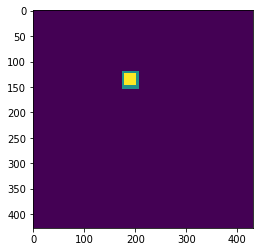

IoU is 0.041643


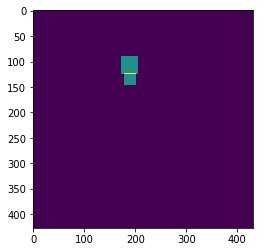

IoU is 0.663317


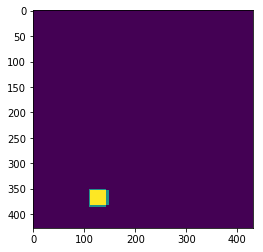

[0.0,
 0.7424242424242424,
 0.7989031078610603,
 0.6690140845070423,
 0.7561436672967864,
 0.5862068965517241,
 0.5,
 0.8115942028985508,
 0.582258064516129,
 0.6987060998151571,
 0.4491017964071856,
 0.8432055749128919,
 0.5604395604395604,
 0.8461538461538461,
 0.5872170439414115,
 0.5442764578833693,
 0.0,
 0.4861111111111111,
 0.56071964017991,
 0.147119341563786,
 0.0,
 0.3877551020408163,
 0.0,
 0.4114285714285714,
 0.47020408163265304,
 0.04164256795835743,
 0.6633165829145728]

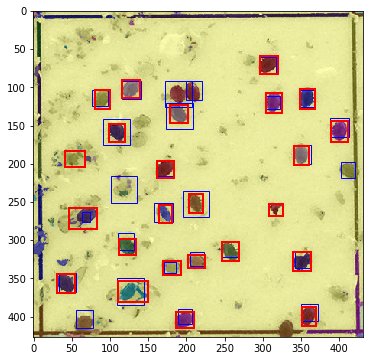

In [44]:
iou_figure2 = IoU(ic[1], imgList[1], regions[1], annotations_xmls[1], 1)
iou_figure2

IoU is 0.754717


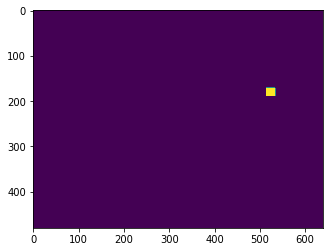

IoU is 0.500693


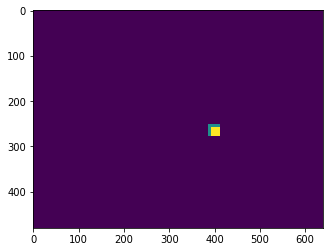

IoU is 0.699029


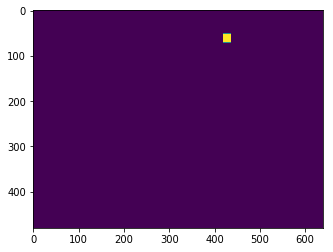

IoU is 0.531309


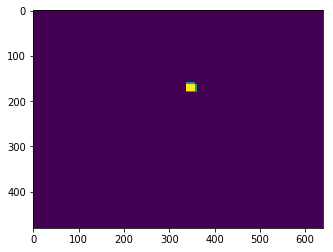

IoU is 0.337596


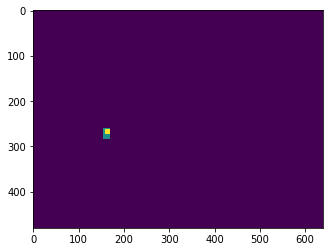

IoU is 0.671141


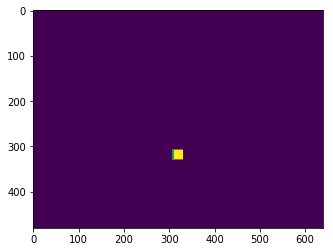

IoU is 0.592982


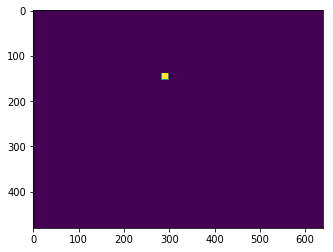

IoU is 0.733945


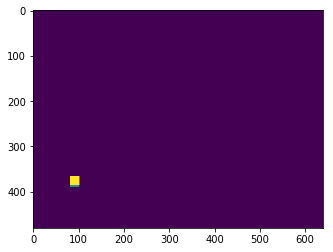

IoU is 0.653846


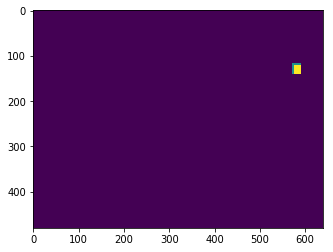

IoU is 0.546218


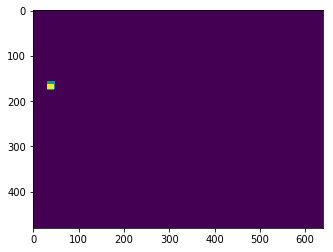

IoU is 0.553279


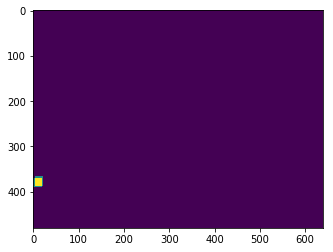

IoU is 0.481651


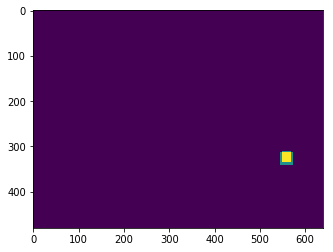

IoU is 0.001495


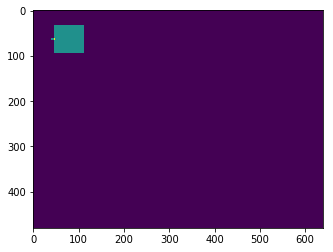

IoU is 0.151261


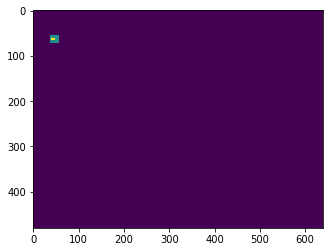

IoU is 0.417010


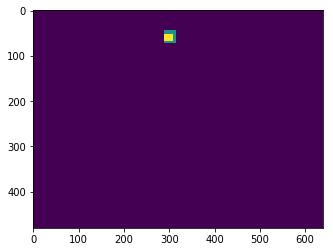

IoU is 0.582661


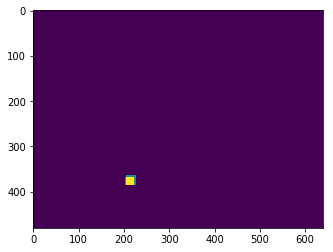

IoU is 0.347087


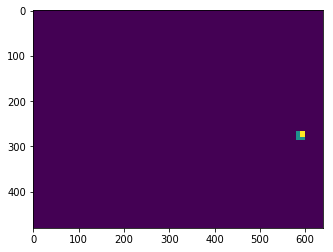

IoU is 0.609218


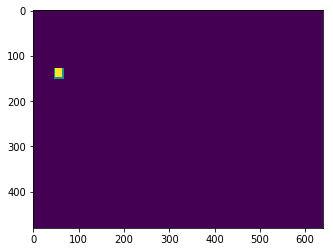

IoU is 0.593814


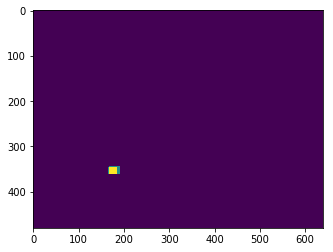

IoU is 0.703704


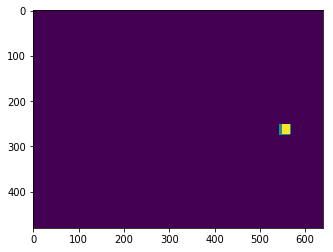

IoU is 0.258311


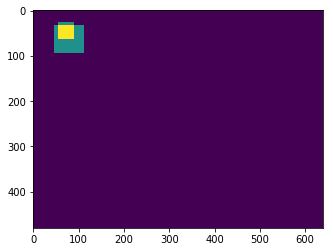

IoU is 0.196759


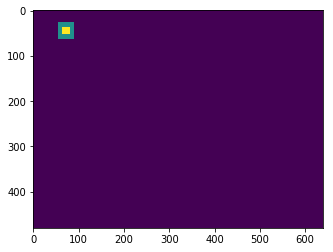

IoU is 0.014733


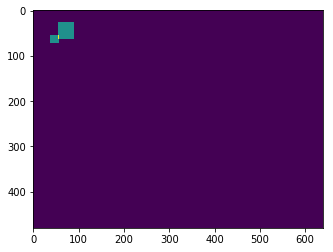

[0.7547169811320755,
 0.5006934812760055,
 0.6990291262135923,
 0.5313092979127134,
 0.3375959079283887,
 0.6711409395973155,
 0.5929824561403508,
 0.7339449541284404,
 0.6538461538461539,
 0.5462184873949579,
 0.5532786885245902,
 0.0,
 0.481651376146789,
 0.15126050420168066,
 0.4170096021947874,
 0.5826612903225806,
 0.3470873786407767,
 0.0,
 0.6092184368737475,
 0.0,
 0.0,
 0.5938144329896907,
 0.7037037037037037,
 0.25831140875388664,
 0.0,
 0.0]

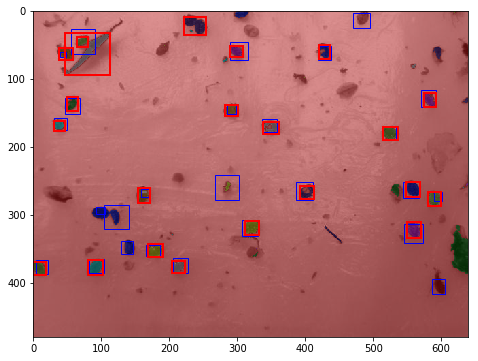

In [45]:
iou_figure3 = IoU(ic[2], imgList[2], regions[2], annotations_xmls[2], 1)
iou_figure3

IoU is 0.722222


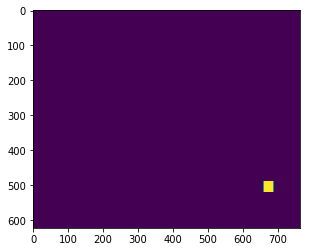

IoU is 0.521078


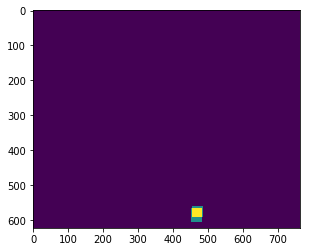

IoU is 0.605067


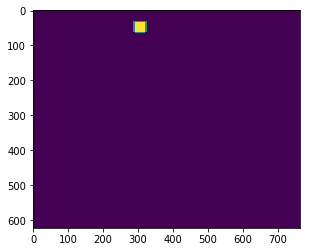

IoU is 0.675784


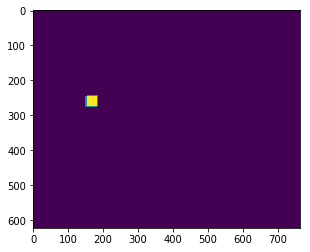

IoU is 0.711676


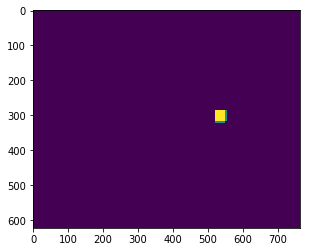

IoU is 0.583065


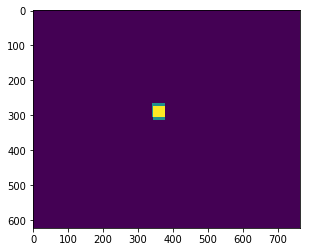

IoU is 0.606613


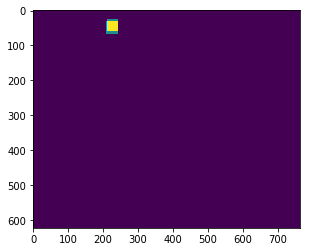

IoU is 0.264706


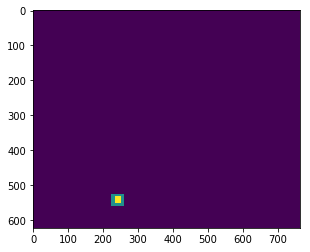

IoU is 0.594796


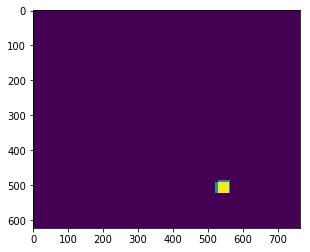

IoU is 0.643963


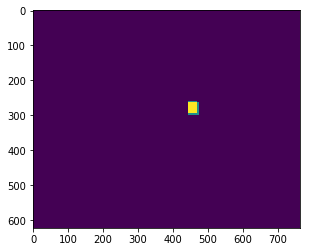

IoU is 0.673012


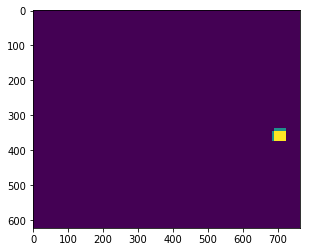

IoU is 0.513376


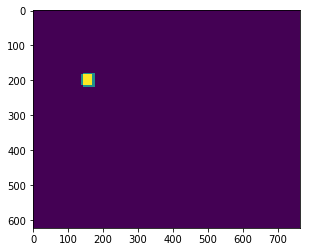

IoU is 0.663957


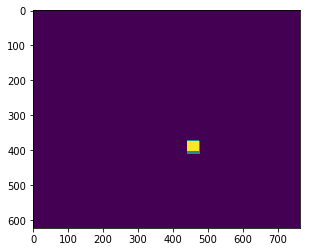

IoU is 0.500000


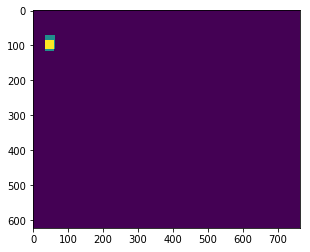

IoU is 0.757778


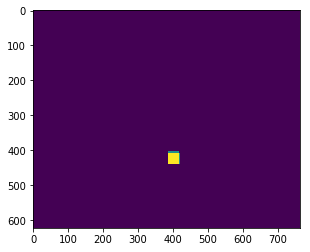

[0.7222222222222222,
 0.5210780926053905,
 0.6050670640834576,
 0.6757843925985519,
 0.7116759332803813,
 0.5830653804930332,
 0.606612685560054,
 0.2647058823529412,
 0.5947955390334573,
 0.6439628482972136,
 0.6730115567641061,
 0.513375796178344,
 0.6639566395663956,
 0.5,
 0.7577777777777778]

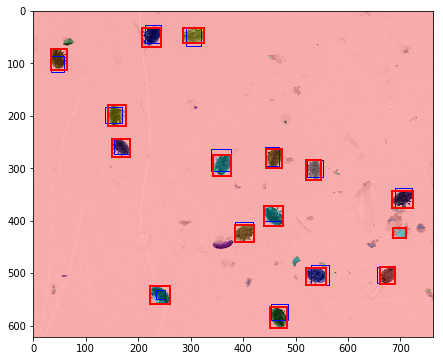

In [46]:
iou_figure4 = IoU(ic[3], imgList[3], regions[3], annotations_xmls[3], 1)
iou_figure4

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

In the part, we calculate the related statistical performance of our predictive model. We find that as no iou value is larger than 0.9, therefore, all there statistics are 0.

In [47]:
def getStat(originImg, imgLabel, regions, gtanno, T):
    ious = IoU(originImg, imgLabel, regions, gtanno)
    sizeLabel = len(regions)
    sizeAnno = len(gtanno)
    
    tp = np.sum(np.array(ious) >= T)
    
    precision = tp / sizeLabel
    recall = tp / sizeAnno
    f1 = 0.0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1

### Threshold=0.5

In [48]:
idx_fly = 0
stats1 = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.5)
print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly+1, stats1[0], stats1[1], stats1[2]))

1th picture: Accuracy=0.3333333333333333 Recall=0.3333333333333333 F1=0.3333333333333333


In [49]:
idx_fly = 1
stats2 = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.5)
print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly, stats2[0], stats2[1], stats2[2]))

1th picture: Accuracy=0.6666666666666666 Recall=0.5925925925925926 F1=0.627450980392157


In [50]:
idx_fly = 2
stats3 = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.5)
print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly, stats3[0], stats3[1], stats3[2]))

2th picture: Accuracy=0.6363636363636364 Recall=0.5384615384615384 F1=0.5833333333333334


In [51]:
idx_fly = 3
stats4 = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.5)
print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly, stats4[0], stats4[1], stats4[2]))

3th picture: Accuracy=0.875 Recall=0.9333333333333333 F1=0.9032258064516129


### Threshold=0.9

In [52]:
for idx_fly in range(4):
    stats = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.9)
    print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly, stats[0], stats[1], stats[2]))

0th picture: Accuracy=0.0 Recall=0.0 F1=0.0
1th picture: Accuracy=0.0 Recall=0.0 F1=0.0
2th picture: Accuracy=0.0 Recall=0.0 F1=0.0
3th picture: Accuracy=0.0 Recall=0.0 F1=0.0


As no results when T = 0.9, we can try the case T = 0.75

In [53]:
for idx_fly in range(4):
    stats = getStat(ic[idx_fly], imgList[idx_fly], regions[idx_fly], annotations_xmls[idx_fly], 0.75)
    print('{}th picture: Accuracy={} Recall={} F1={}'.format(idx_fly, stats[0], stats[1], stats[2]))

0th picture: Accuracy=0.0 Recall=0.0 F1=0.0
1th picture: Accuracy=0.20833333333333334 Recall=0.18518518518518517 F1=0.19607843137254902
2th picture: Accuracy=0.045454545454545456 Recall=0.038461538461538464 F1=0.04166666666666667
3th picture: Accuracy=0.0625 Recall=0.06666666666666667 F1=0.06451612903225808


Pretty Low!!!!

### Analysis:
Base on the performance, I analysize several reasons:
- 1. The groundtruth is not that 'truth'. There are some misses and mistakes in the groundtruth.
- 2. We can do better in the threshold selection, and it seems that we have labelled some others like leaves wrontly.
- 3. The shape of our labels does not perfectly match with the groundtruth, and it may be more reasonable to use other measurement.